In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms)

test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

In [4]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 10           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 120         # latent vector dimension
N_CLASSES = 10          # number of classes in the data
lr = 1e-3               # learning rate

In [5]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

In [7]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var

In [8]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x


In [9]:
class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):

        x = torch.cat((x, y), dim=1)

        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var

In [10]:
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES)

#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

In [12]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [13]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1))
            y = y.to(device)

            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss


In [14]:
for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    patience_counter = 0
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
    best_test_loss =0
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

/Users/adithyaiyer/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/adithyaiyer/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 162.24, Test Loss: 132.63
Epoch 1, Train Loss: 124.18, Test Loss: 116.27
Epoch 2, Train Loss: 113.92, Test Loss: 110.36
Epoch 3, Train Loss: 109.89, Test Loss: 108.28
Epoch 4, Train Loss: 107.68, Test Loss: 106.00
Epoch 5, Train Loss: 106.28, Test Loss: 105.17
Epoch 6, Train Loss: 105.28, Test Loss: 104.23
Epoch 7, Train Loss: 104.54, Test Loss: 103.89
Epoch 8, Train Loss: 103.94, Test Loss: 103.04
Epoch 9, Train Loss: 103.46, Test Loss: 102.93


Generating a 4


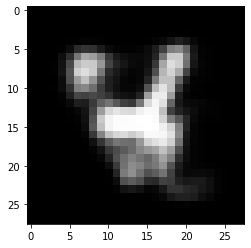

In [42]:
z = torch.randn(1, LATENT_DIM).to(device)

# pick randomly 1 class, for which we want to generate the data
y = torch.randint(0, N_CLASSES, (1, 1)).to(dtype=torch.long)
print(f'Generating a {y.item()}')

y = idx2onehot(y).to(device, dtype=z.dtype)
z = torch.cat((z, y), dim=1)

reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28, 28).data

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

In [18]:
import numpy as np
(np.random.rand(23,23)>0.5)

array([[ True,  True,  True, False, False,  True,  True, False,  True,
         True,  True, False, False,  True,  True,  True, False, False,
         True, False,  True,  True,  True],
       [False,  True, False,  True,  True,  True, False,  True, False,
         True,  True, False, False, False, False,  True, False, False,
        False,  True, False,  True, False],
       [ True,  True,  True,  True, False,  True, False,  True, False,
        False,  True,  True, False,  True, False, False,  True,  True,
         True,  True, False, False, False],
       [False, False, False,  True,  True, False,  True,  True,  True,
        False, False, False,  True,  True, False, False, False,  True,
         True, False, False, False,  True],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False, False,  True, False,  True,  True,  True, False,
        False,  True, False,  True,  True],
       [ True,  True,  True, False,  True,  True,  True, False,  True,